# Mean-Variance Sig Trading

### Underlying Process: 1-dimensional OU process

This notebook demonstrates some basic usage of the Sig-Trading framework for mean-variance optimisation.
1. Implementation in PyTorch / signatory
2. Implementation in Numpy / iisignature

Whichever method is preferred due to computational speed and device type. PyTorch method allows for cuda/GPU computation.

In [1]:
import notebook_base

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from mean_variance.utils import *
from mean_variance.simulators import *
from mean_variance.sig_trader import *
from data.path import Path

## 1. Implementation in PyTorch

In [2]:
if torch.cuda.is_available(): 
  device = 'cuda'
else: 
  device = 'cpu'

print('device:', device)

device: cuda


### Create OU Data

In [3]:
torch.manual_seed(8)

N = 1000

paths = generate_OU_paths(
    n_samples=2*N,
    n_days=200,
    dt=1, 
    dim=1, 
    S_0=0,
    theta=0.01,
    sigma=0.03, 
    mu=0)+1

train_paths = paths[:N]
test_paths = paths[N:]

### Create, fit & test Sig-Trader

In [4]:
order = 3
ST = SigTrader(order=order)

In [5]:
ST.fit(asset_paths = train_paths, order=order, fast_sol=True, max_var=0.05);

In [6]:
position, pnl = ST.compute_pnl(asset_paths = test_paths)
sample_pos, sample_pnl = ST.compute_pnl(asset_paths = train_paths, order = order)

### PnL

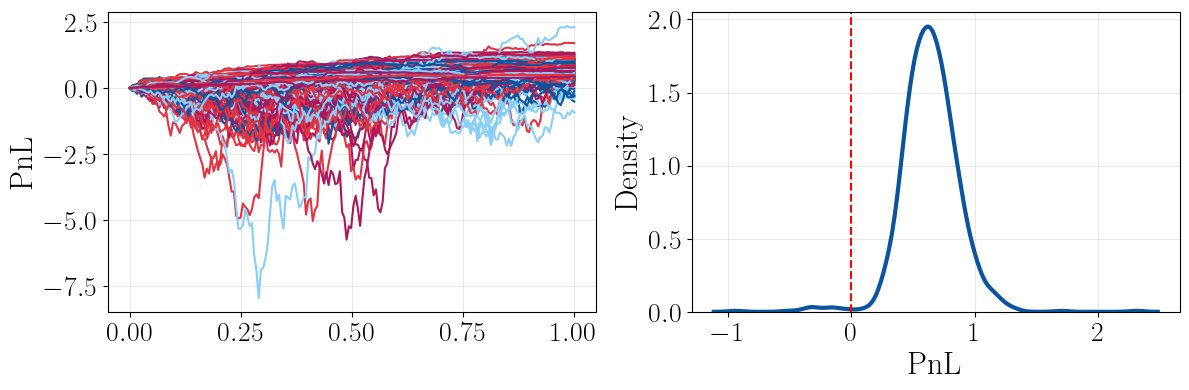

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(np.linspace(0,1,pnl.shape[-1]), pnl.T);
ax[0].set_ylabel('PnL')

sns.kdeplot(pnl[:,-1], label='PnL distribution',ax = ax[1], lw=3)
ax[1].axvline(0, color='r', linestyle='--', label='Zero PnL')
ax[1].set_xlabel('PnL')

for i in range(2):
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()

### Alpha/Risk

In [8]:
# Terminal Expectation (Theoretical)
ST_mu = (ST.l @ ST.mu_sig).item()
print(f"Terminal Expectation (Theoretical): {ST_mu:.4f}")

# Terminal Expectation (Realized)
pnl_mu = sample_pnl[:, -1].mean()
print(f"Terminal Expectation (Realized): {pnl_mu:.4f}")

Terminal Expectation (Theoretical): 0.6270
Terminal Expectation (Realized): 0.6266


In [9]:
# Terminal Variance (Theoretical)
ST_var = (((ST.l) @ ST.var_sig)[-1] @ ST.l.T).item()
print(f"Terminal Variance (Theoretical): {ST_var:.4f}")

# Terminal Variance (Realized)
pnl_var = sample_pnl[:,-1].var(unbiased=False).item()
print(f"Terminal Variance (Realized): {pnl_var:.4f}")

Terminal Variance (Theoretical): 0.0500
Terminal Variance (Realized): 0.0501


## 2. Implementation in Numpy

### Create, fit & test Sig-Trader

In [10]:
ST = SigTrader(order=order, method="numpy")

(CVXPY) May 27 04:41:55 PM: Encountered unexpected exception importing solver SCS:
ImportError('libmkl_rt.so.2: cannot open shared object file: No such file or directory')


In [11]:
ST.fit(asset_paths = train_paths, order=order, fast_sol=True, max_var=0.05);

In [12]:
position, pnl = ST.compute_pnl(asset_paths = test_paths, order = order)
sample_pos, sample_pnl = ST.compute_pnl(asset_paths = train_paths, order = order)

### PnL

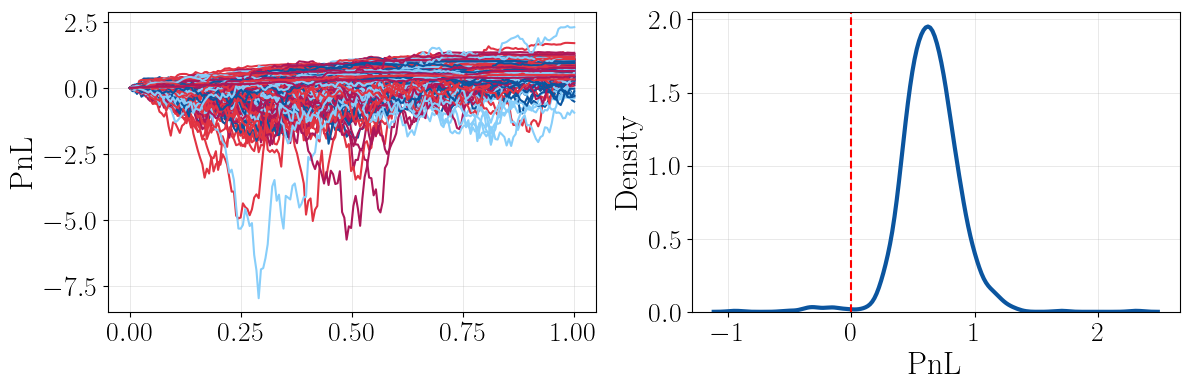

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(np.linspace(0,1,pnl.shape[-1]), pnl.T);
ax[0].set_ylabel('PnL')

sns.kdeplot(pnl[:,-1], label='PnL distribution',ax = ax[1], lw=3)
ax[1].axvline(0, color='r', linestyle='--', label='Zero PnL')
ax[1].set_xlabel('PnL')

for i in range(2):
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()

### Alpha/Risk

In [14]:
# Terminal Expectation (Theoretical in Sample)
ST_mu = (ST.strategy.l_val @ ST.mu_sig).item()
print(f"Terminal Expectation (Theoretical): {ST_mu:.4f}")

# Terminal Expectation (Realized in Sample)
pnl_mu = sample_pnl[:,-1].mean().item()
print(f"Terminal Expectation (Realized): {pnl_mu:.4f}")

Terminal Expectation (Theoretical): 0.6270
Terminal Expectation (Realized): 0.6266


In [15]:
# Terminal Variance (Theoretical in Sample)

ST_var = ((ST.strategy.l_val) @ ST.strategy.var_sig) @ (ST.strategy.l_val.T)
print(f"Terminal Variance (Theoretical): {ST_var:.4f}")

# Terminal Variance (Realized in Sample)

pnl_var = sample_pnl[:,-1].var()
print(f"Terminal Variance (Realized): {pnl_var:.4f}")

Terminal Variance (Theoretical): 0.0500
Terminal Variance (Realized): 0.0501
